<a href="https://colab.research.google.com/github/Piyush434/Machine-Learning/blob/main/Decision_Tree_Classifier_Submission_Piyush_Vasudha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


* **Name: Piyush Bhondave**

*   PRN: 0120200326
*   Lab Batch: ML-2
*   Seat No.: T224090




* Team Mate Name:-
* **Name: Vasudha Kadam**
* PRN: 0120200416
* Seat No.: S224111

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Entropy

In [2]:
import pandas as pd
import numpy as np

def entropy(feature):
    val = feature.value_counts()/feature.shape[0]
    # calculating the entropy
    entropy = np.sum(-val*np.log2(val+1e-9))
    return entropy

In [3]:
# let's test with the titanic dataset's Gender column
dt = pd.read_csv("/content/drive/My Drive/Colab Notebooks/MLSem6Assg/train.csv")
entropy(dt["Sex"])

0.9362046403644619

# Gini Impurity

In [4]:
def gini_impurity(feature):
    p = feature.value_counts()/feature.shape[0]
    # applying the ginin index formula
    gini_index = 1-np.sum(p**2)
    return gini_index

In [5]:
#titanic dataset's Gender column
gini_impurity(dt["Sex"])

0.4564361661256535

# Information Gain

In [6]:
def information_gain(feature, mask):
    sum_a = sum(mask)
    b = mask.shape[0] - sum_a
    if(sum_a == 0 or b ==0): 
        information_g = 0
    else:
        if feature.dtypes != 'O':
            information_g = feature.var() - (sum_a/(sum_a+b)* feature[mask]).var() - (b/(sum_a+b)*feature[-mask]).var()
        else:
            information_g = entropy(feature)-sum_a/(sum_a+b)*entropy(feature[mask])-b/(sum_a+b)*entropy(feature[-mask])
    return information_g

In [7]:
print(information_gain(dt['Survived'], dt["Sex"] == "male"))

0.14855514166524095


# Decison Tree Class Implemented from Scra

In [8]:
from collections import Counter
import numpy as np

class decision_Tree:
  
    def __init__(self):
        self.no_of_unique=6 
        self.counter=0 
        self.min_samples=15 
        self.max_depth=10 
  
    def type_of_cols(self,data):

        col_type=[]
        for col in data.columns[:-1]:
            no_of_col_unique= data[col].nunique()
            if data[col].dtypes==object or no_of_col_unique < self.no_of_unique:
                col_type.append("categorical")
            else:
                col_type.append("continuous")
        return col_type

    def get_splits(self,data):
        splits = {} 
        feature_type=self.type_of_cols(data) 

        for column_index in range(data.shape[1]-1):          
        
            values = data.iloc[:, column_index] 
            unique_values = np.unique(values) 
            type_of_feature = feature_type[column_index] 

            if type_of_feature == "continuous":
                splits[column_index] = []
                for index in range(len(unique_values)):
                    if index != 0:
                        current_value = unique_values[index]
                        previous_value = unique_values[index - 1]
                        split = (current_value + previous_value) / 2 
                        splits[column_index].append(split) 

            elif len(unique_values) > 1:
                splits[column_index] = unique_values
    
        return splits
    def split_data(self,data, column, value):

        feature_type=self.type_of_cols(data)
        split_values = data.iloc[:,column]
        type_of_feature = feature_type[column]
        if type_of_feature == "continuous": 
            left = data[split_values <= value]
            right = data[split_values >  value]
        else:
            left = data[split_values == value]
            right = data[split_values != value]
    
        return left,right
    def entropy(self,data):
        prob=list(dict(data.iloc[:, -1].value_counts(normalize=True)).values())
        entropy = sum(prob* -np.log2(prob))    
        return entropy
    def entropy_data(self,left,right):    
        n = len(left) + len(right)
        p_left = len(left) / n
        p_right = len(right) / n
        entropy_ =  (p_left * self.entropy(left)+ p_right *self.entropy(right))
        return entropy_

    def best_split(self,data,splits):
        
        entropy = 99999
       
        for col in splits: 
            for val in splits[col]: 
                left, right = self.split_data(data, column=col, value=val)
                current_entropy = self.entropy_data(left,right) 
                if current_entropy <= entropy:  
                    entropy = current_entropy 
                    best_column = col 
                    best_split = val
        return best_column, best_split
  
    def _tree_builder(self,df):
        column=df.columns 
        feature_type=self.type_of_cols(df) 
        data = df
        

        if  (df.iloc[:,-1].nunique()==1) or (len(data) < self.min_samples) or (self.counter == self.max_depth):
            classes= Counter(df.iloc[:,-1]).most_common(1)[0][0]
            return classes
        else:    
            self.counter += 1
            splits = self.get_splits(data)
            split_column, split_value = self.best_split(data,splits)
            left, right = self.split_data(data, split_column, split_value) 
            
            
            feature_name = column[split_column] 
            type_of_feature = feature_type[split_column] 
            if type_of_feature == "continuous":
                question = "{} <= {}".format(feature_name, split_value) 
            else:
                question = "{} = {}".format(feature_name, split_value)
          
            mytree = {question: []}
            ans_yes = self._tree_builder(left) 
            ans_no = self._tree_builder(right) 

            if ans_yes == ans_no:
                mytree = ans_yes
            else:
                mytree[question].append(ans_yes)
                mytree[question].append(ans_no)

            return mytree
    def fit(self,X,y):
        X["output"]=y

        self.tree=self._tree_builder(X)
        return self.tree

    def _predict(sf,dx,tree):
        root_node = list(tree.keys())[0] 
        column,operator,split=root_node.split(" ") 
        if operator == "<=": 
            if dx[column] <= float(split):
                result = tree[root_node][0]
            else:
                result = tree[root_node][1]

        else:
            if str(dx[column]) == split:
                result = tree[root_node][0]
            else:
                result = tree[root_node][1]
        
        if type(result)!=dict: 
            return result
       
        else:
            return sf._predict(dx,result)


    def predict(self,X_test):
        s=[] 
        
        for i in range(X_test.shape[0]):
            s.append(self._predict(X_test.iloc[i],self.tree))
        return s

# Applying on Dataset





In [9]:
import warnings
warnings.filterwarnings('ignore')

from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
dt.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


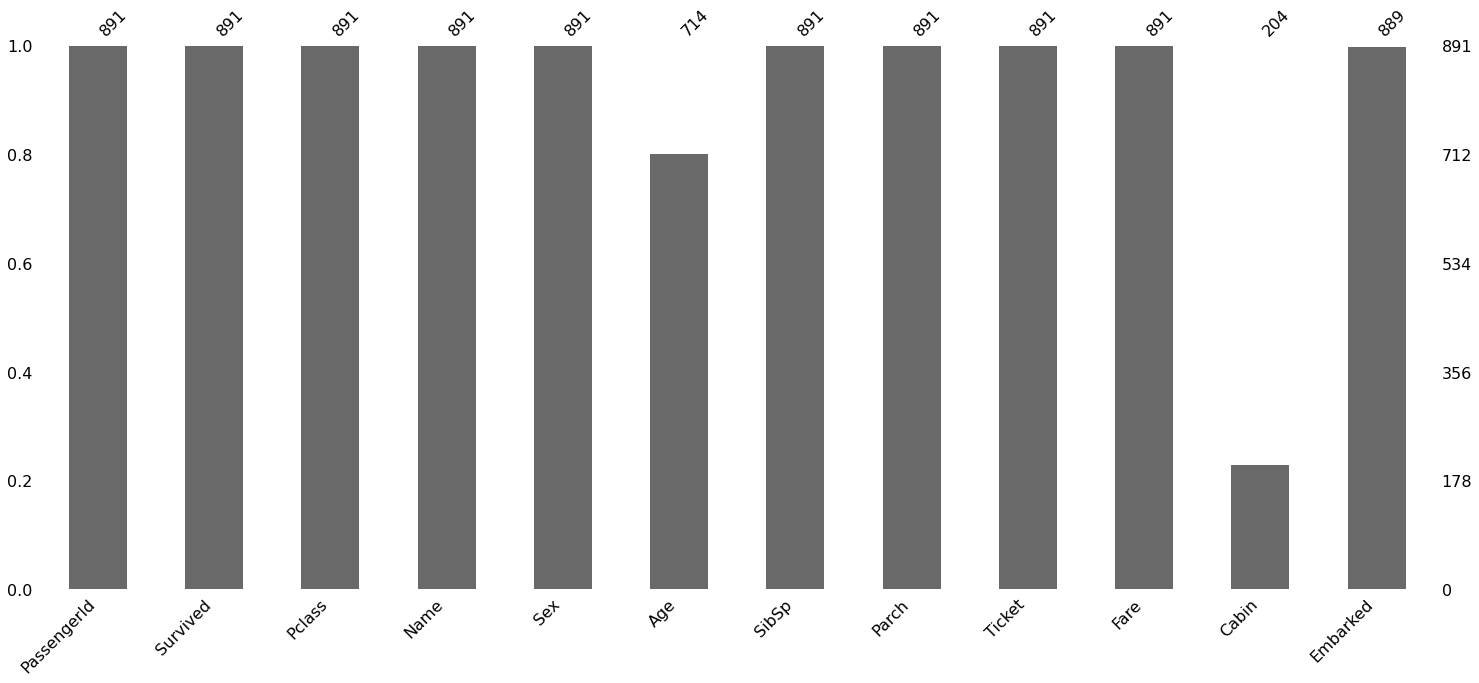

In [12]:
msno.bar(dt)
plt.show()

In [13]:

dt.Age = dt.Age.fillna(dt.Age.median())
dt = dt.drop(["Name","Ticket","Cabin","PassengerId"],axis=1)

dt = dt.dropna()
dt = dt.drop(dt.index[dt['Embarked'] == 29.69911764705882].tolist(),axis=0)

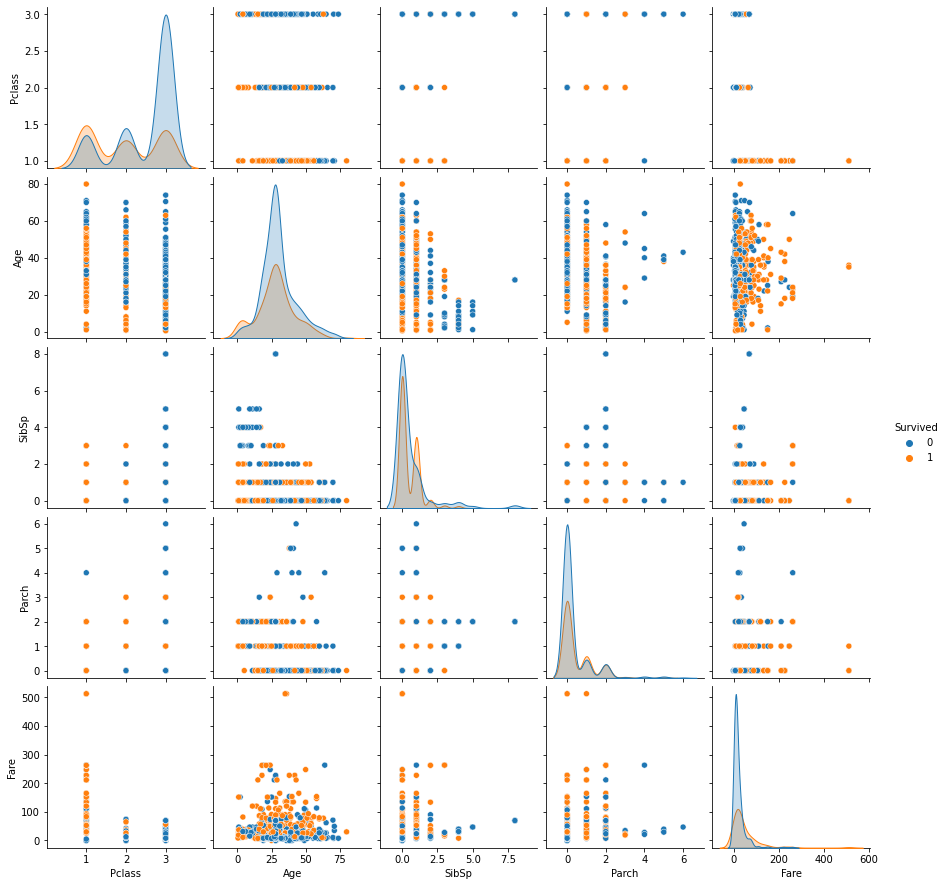

In [14]:
sns.pairplot(data=dt, hue = 'Survived')

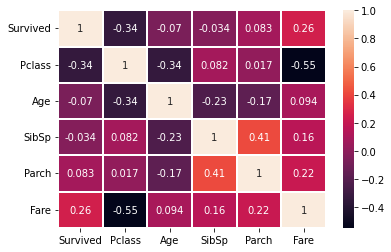

In [15]:
sns.heatmap(dt.corr(), annot = True, linewidths = 1)

In [16]:
dt= pd.get_dummies(dt)
X,y = dt.drop(["Survived"],axis=1),dt['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.23, random_state=42)

In [17]:
ob = decision_Tree()
ob.fit(X_train,y_train,)
print(ob.tree)

{'Sex_male = 1': [{'Fare <= 26.26875': [{'Age <= 13.5': [1, {'Age <= 45.25': [{'Embarked_C = 1': [{'Fare <= 15.1479': [{'Fare <= 7.2271': [0, {'Fare <= 14.15835': [{'Fare = 13.8625': [1, 0]}, 0]}]}, 1]}, 0]}, 0]}]}, 0]}, 1]}


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       129
           1       0.37      1.00      0.54        76

    accuracy                           0.37       205
   macro avg       0.19      0.50      0.27       205
weighted avg       0.14      0.37      0.20       205



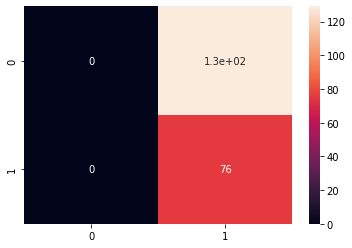

In [18]:

y_pred = ob.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)

print(classification_report(y_test,y_pred))

# Compairing with Sklearn Decision Tree Classifier


              precision    recall  f1-score   support

           0       0.83      0.78      0.80       129
           1       0.66      0.74      0.70        76

    accuracy                           0.76       205
   macro avg       0.75      0.76      0.75       205
weighted avg       0.77      0.76      0.76       205



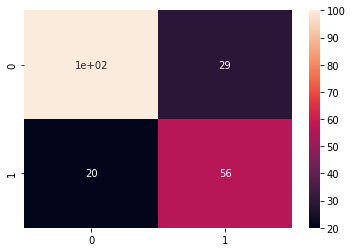

In [19]:
X,y = dt.drop(["Survived"],axis=1),dt['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.23, random_state=42)
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)

print(classification_report(y_test,y_pred))

# Compairing with Random Forest 

In [20]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

In [21]:
# train model
model.fit(X_train,y_train)

RandomForestClassifier()

In [22]:
# predict with model
y_pred=model.predict(X_test)

              precision    recall  f1-score   support

           0       0.82      0.80      0.81       129
           1       0.67      0.70      0.68        76

    accuracy                           0.76       205
   macro avg       0.74      0.75      0.75       205
weighted avg       0.76      0.76      0.76       205



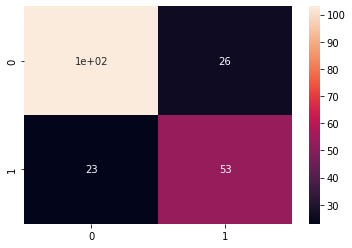

In [23]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)

print(classification_report(y_test,y_pred))